In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import tensorflow as tf

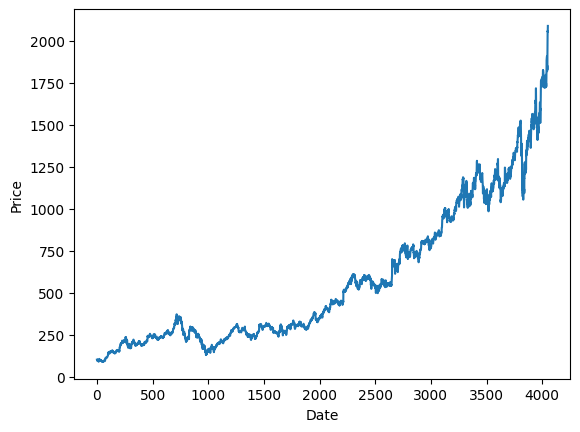

In [6]:
# Download stock data and plot the history diagram

import yfinance as yf
from datetime import datetime

stockName = "GOOGL"
stkTicker = yf.Ticker(stockName)
dataHist = stkTicker.history(start="2005-01-01", end=datetime.today().strftime('%Y-%m-%d'), interval = "1d")
dataClose = dataHist['Close'].to_numpy()
dataClose = dataClose.reshape(-1,1)
np.set_printoptions(threshold=np.inf)
plt.style.use("default")
plt.xlabel("Date")
plt.ylabel("Price")
plt.plot(dataClose)

In [7]:
# Preprocess the historical data
# Format data array to LSTM
# -----------------------------------------------------------------------------------
#|  0-4044(4045)    dataClose, dataOpen, dataHist                                    |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|  1-4044(4044)    dataClose   dataset                                              |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|         datasetTrain                           |   datasetTest                    |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|         0-2446  xTrain             | 2447-2546 |                                  |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|       0-99     |     100-2546     yTrain      |                                  |
# -----------------------------------------------------------------------------------

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# ------------------x = Percentage--------------------
dataPer = []
for i in range(dataClose.size):
    if i == 0:
        dataPer.append(0.00)
    else:
        dataPer.append(math.log(dataClose[i] / dataClose[i-1]))
        #if dataClose[i] >= dataClose[i-1]:
            #dataPer.append(math.log(dataClose[i] / dataClose[i-1]))
        #else:
            #dataPer.append(0)
dataset = np.array(dataPer)
dataset = dataset.reshape(-1,1)

minmaxScaler = MinMaxScaler(feature_range=(0, 1), copy=True)
_dataset = minmaxScaler.fit_transform(dataset)
print("The max =", minmaxScaler.data_max_,", the Min =",minmaxScaler.data_min_)

The max = [0.18225111] , the Min = [-0.12368463]


In [8]:
# Get train set and test set

sizeTrain = int(_dataset.size*0.63)
sizeTest = _dataset.size - sizeTrain
print("The length of data is:",_dataset.size, \
      "\nThe length of Training is:", sizeTrain, \
      "\nThe length of Testing is:", sizeTest)
_Train = _dataset[ : sizeTrain, : ]
_Test = _dataset[sizeTrain : , : ]

The length of data is: 4052 
The length of Training is: 2552 
The length of Testing is: 1500


In [13]:
# Format data array to LSTM
# -----------------------------------------------------------------------------------
#|  0-4044(4045)    dataClose, dataOpen, dataHist                                    |
# -----------------------------------------------------------------------------------
# -----------------------------------------------------------------------------------
#|  0  |   1-4044(4044)                                                              |
# -----------------------------------------------------------------------------------
#      ------------------------------------------------------------------------------
#     |    datasetTrain                           |   datasetTest                    |
#      ------------------------------------------------------------------------------
#      ------------------------------------------------------------------------------
#     |    0-2446  xTrain             | 2447-2546 |                                  |
#      ------------------------------------------------------------------------------
#      ------------------------------------------------------------------------------
#     |   0-99     |     100-2546     yTrain      |                                  |
#      ------------------------------------------------------------------------------

DIM_LSTM = 100

def formatData(dataSet,dimLSTM):
    X,Y = [],[]
    for i in range(dataSet.size - dimLSTM):
        X.append(dataSet[i : i+dimLSTM, : ])
        Y.append(dataSet[i + dimLSTM, : ])
    X = np.array(X)
    Y = np.array(Y)
    X = X.reshape(-1,dimLSTM)
    Y = Y.reshape(-1,1)
    X = X.reshape(X.shape[0], X.shape[1],1)
    return X,Y
_xTrain, _yTrain = formatData(_Train, DIM_LSTM)
_xTest, _yTest = formatData(_Test, DIM_LSTM)
xTrain, yTrain = formatData(dataset[ : sizeTrain, : ], DIM_LSTM)
xTest, yTest = formatData(dataset[sizeTrain : , : ], DIM_LSTM)
xTrainClose, yTrainClose = formatData(dataClose[ : sizeTrain, : ], DIM_LSTM)
xTestClose, yTestClose = formatData(dataClose[sizeTrain : , : ], DIM_LSTM)

In [14]:
# Build the model

import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM

def my_loss_fn(y_true, y_pred):
    #base = tf.where(tf.logical_and(tf.greater_equal(y_pred,1), tf.greater_equal(y_true,1)), tf.zeros_like(y_true), tf.ones_like(y_true))
    #base = tf.where(tf.logical_and(tf.less(y_pred,1), tf.less(y_true,1)), tf.zeros_like(y_true), base)
    #base = tf.where(tf.logical_and(tf.greater_equal(y_pred,1), tf.less(y_true,1)), tf.math.negative(tf.math.log(y_true)), base)
    #base = tf.where(tf.logical_and(tf.less(y_pred,1), tf.greater_equal(y_true,1)), tf.math.log(y_true), base)
    base = tf.where(tf.logical_and(tf.greater_equal(y_pred,0), tf.greater_equal(y_true,0)), tf.zeros_like(y_true), tf.ones_like(y_true))
    base = tf.where(tf.logical_and(tf.less(y_pred,0), tf.less(y_true,0)), tf.zeros_like(y_true), base)
    base = tf.where(tf.logical_and(tf.greater_equal(y_pred,0), tf.less(y_true,0)), tf.math.negative(y_true), base)
    base = tf.where(tf.logical_and(tf.less(y_pred,0), tf.greater_equal(y_true,0)), y_true, base)
    loss = tf.square(base)
    return loss

UNIT_LSTM = 50
model = keras.Sequential()
model.add(LSTM(UNIT_LSTM, return_sequences = True, use_bias = True, input_shape=(DIM_LSTM,1)))
model.add(LSTM(UNIT_LSTM, return_sequences = True, use_bias = True))
model.add(LSTM(UNIT_LSTM, use_bias = True))
model.add(Dense(1, use_bias = True))
model.compile(loss='mean_squared_error', optimizer = 'adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Fit the model   
model.fit(_xTrain,_yTrain,validation_data=(_xTest,_yTest), epochs=10, batch_size=16, verbose =1)

Epoch 1/10
154/154 [==============================] - 26s 139ms/step - loss: 0.0180 - val_loss: 0.0032
Epoch 2/10
154/154 [==============================] - 20s 132ms/step - loss: 0.0042 - val_loss: 0.0044
Epoch 3/10
154/154 [==============================] - 20s 132ms/step - loss: 0.0045 - val_loss: 0.0033
Epoch 4/10
154/154 [==============================] - 20s 133ms/step - loss: 0.0044 - val_loss: 0.0044
Epoch 5/10
154/154 [==============================] - 20s 132ms/step - loss: 0.0045 - val_loss: 0.0036
Epoch 6/10
154/154 [==============================] - 20s 133ms/step - loss: 0.0045 - val_loss: 0.0032
Epoch 7/10
154/154 [==============================] - 21s 136ms/step - loss: 0.0041 - val_loss: 0.0035
Epoch 8/10
154/154 [==============================] - 21s 134ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 9/10
154/154 [==============================] - 20s 132ms/step - loss: 0.0044 - val_loss: 0.0033
Epoch 10/10
154/154 [==============================] - 21s 134ms/step - l

In [16]:
# Make predictions

from sklearn.metrics import mean_squared_error

_predTrain = model.predict(_xTrain)
_predTest= model.predict(_xTest)
predTrain = minmaxScaler.inverse_transform(_predTrain)
predTest = minmaxScaler.inverse_transform(_predTest)
mean_squared_error(predTrain,yTrain)

0.00045836720465017506

In [23]:
def PredDistb(pred,close):
    i = pred.min()
    _win = []
    _lose = []
    _i = []
    while i<= pred.max():
        win = 0
        lose = 0
        for j in range(1,pred.size,1):
            if pred[j] >= i and pred[j] < i+(pred.max()-pred.min())/10:
                if close[j] > close[j-1] :
                    win = win + 1                
                else:
                    lose = lose + 1
        if win+lose == 0:
            _win.append(0)
            _lose.append(0)
        else:
            #_win.append(win/(win+lose))
            #_lose.append(lose/(win+lose))
            _win.append(win)
            _lose.append(lose)
        _i.append(math.exp(i))
        i=i+(pred.max()-pred.min())/10
        
    _win = np.array(_win).reshape(-1,1)
    _lose = np.array(_lose).reshape(-1,1)
    _i = np.array(_i).reshape(-1,1)
    plt.figure(figsize=(20, 6))
    plt.xticks(np.linspace(math.exp(pred.min()), math.exp(pred.max()), 11))
    plt.grid(ls='--')
    plt.plot(_i, _win, color='green', label='win')
    plt.plot(_i, _lose, color='red', label='lose')
    plt.xlabel('predTest')
    plt.ylabel('rate of win/lose')
    plt.legend()

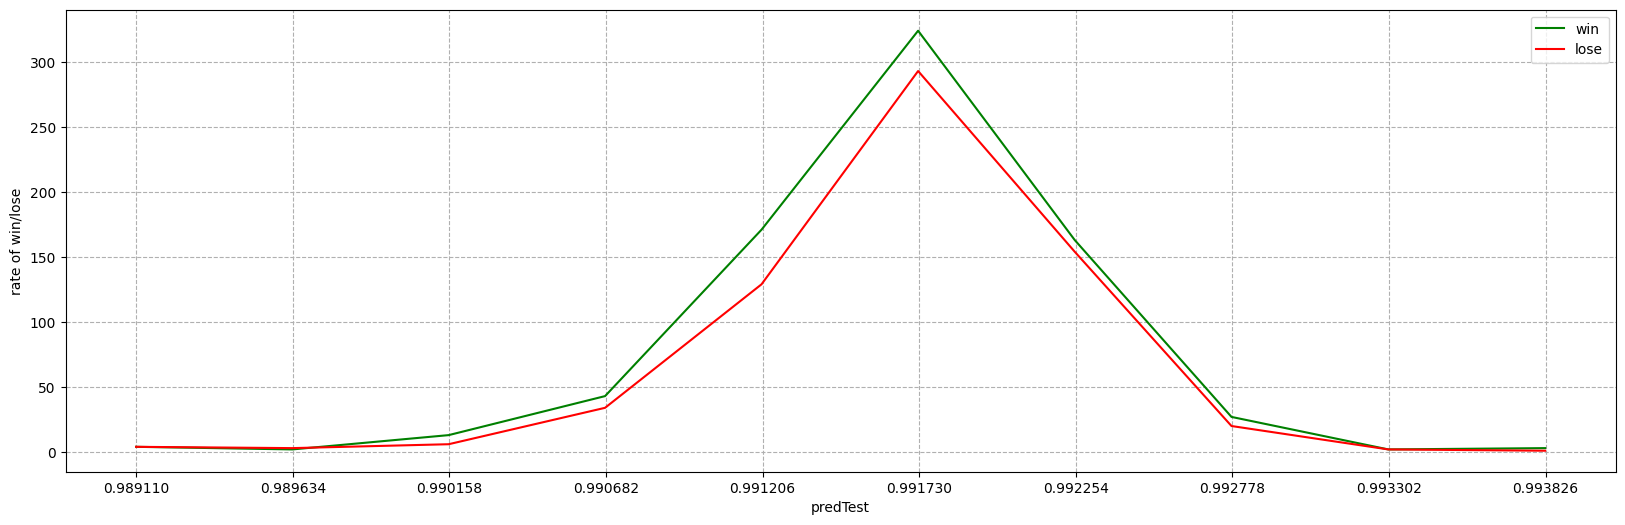

In [24]:
PredDistb(predTest,yTestClose)

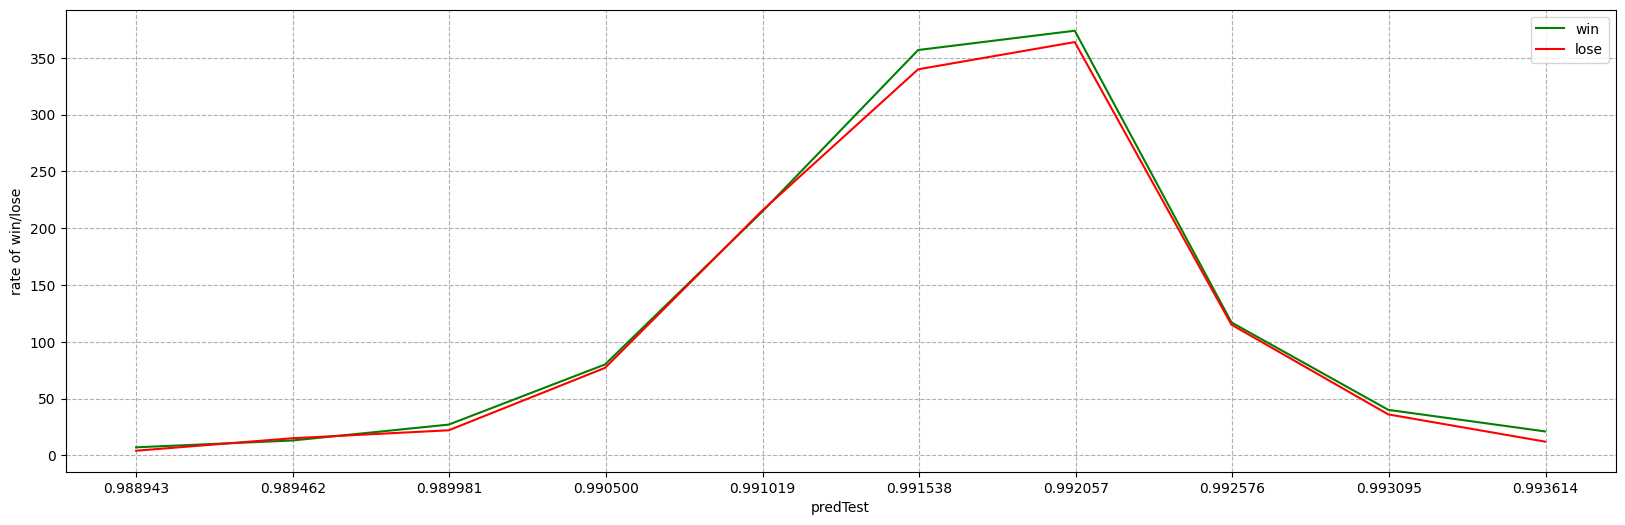

In [25]:
PredDistb(predTrain,yTrainClose)

In [ ]:
def SumRes(pred,close,lever,isPrint):
    pred = pred.flatten()
    j = 0
    for i in range(pred.size):
        if i == 0:
            gain = 1
        else:
            if predTrain[i] < 0.007:
                j=j+1
                gain = gain * (close[i-1] + lever * (close[i]-close[i-1])) / close[i-1]
                if isPrint !=0:
                    print(i, "\tCurrClose:%.02f" %close[i], \
                             "  \tPredCurrGain%+.07f" %pred[i], \
                             "  \tActualGain%+.02f" %(close[i]/close[i-1]), \
                             "  \tPredLongTermGain%+.02f" %gain)
    if isPrint !=0:
        print("\n\n\nFinal gain comparasion:\t",gain,"rather than Long-Term-Gain",close[pred.size-1]/close[0],", Trading times",j)
    return gain
    

In [ ]:
def dispLever(pred,close,):
    disp  = []
    lever = []
    l = float(0)
    while l<=10:
        disp.append(SumRes(pred,close,l,0))
        lever.append(l)
        l=l+0.1
    disp = np.array(disp).reshape(-1,1)
    lever = np.array(lever).reshape(-1,1)
    plt.figure(figsize=(10, 6))
    plt.xticks(np.linspace(0, 10, 21))
    plt.grid(ls='--')
    plt.plot(lever, disp)

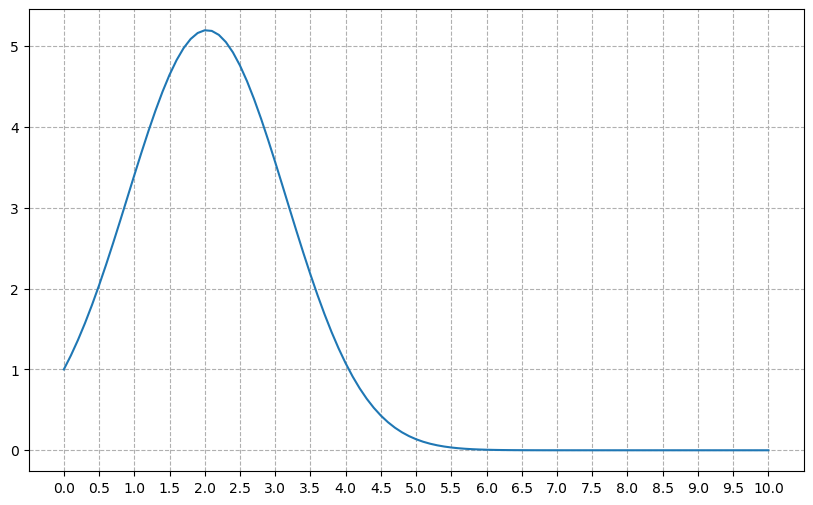

In [ ]:
dispLever(predTrain,yTrainClose)

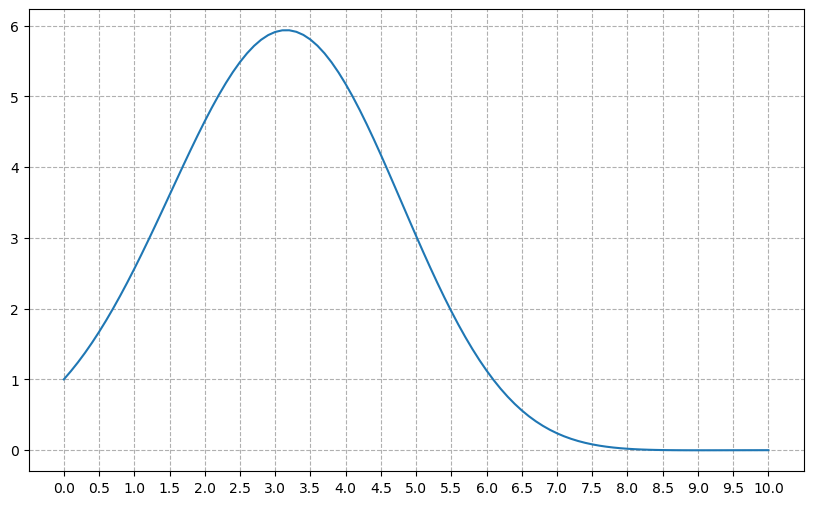

In [ ]:
dispLever(predTest,yTestClose)

In [ ]:
SumRes(predTrain,yTrainClose,2.25,1) 

1 	CurrClose:96.87   	PredCurrGain+0.0064497   	ActualGain+0.99   	PredLongTermGain+0.98
2 	CurrClose:97.79   	PredCurrGain+0.0065058   	ActualGain+1.01   	PredLongTermGain+1.00
3 	CurrClose:97.76   	PredCurrGain+0.0065592   	ActualGain+1.00   	PredLongTermGain+1.00
4 	CurrClose:100.09   	PredCurrGain+0.0065817   	ActualGain+1.02   	PredLongTermGain+1.06
5 	CurrClose:102.05   	PredCurrGain+0.0064585   	ActualGain+1.02   	PredLongTermGain+1.10
6 	CurrClose:98.75   	PredCurrGain+0.0065436   	ActualGain+0.97   	PredLongTermGain+1.02
7 	CurrClose:97.06   	PredCurrGain+0.0066274   	ActualGain+0.98   	PredLongTermGain+0.98
8 	CurrClose:94.23   	PredCurrGain+0.0065928   	ActualGain+0.97   	PredLongTermGain+0.92
9 	CurrClose:90.45   	PredCurrGain+0.0065971   	ActualGain+0.96   	PredLongTermGain+0.84
10 	CurrClose:88.65   	PredCurrGain+0.0064113   	ActualGain+0.98   	PredLongTermGain+0.80
11 	CurrClose:94.71   	PredCurrGain+0.0062629   	ActualGain+1.07   	PredLongTermGain+0.92
12 	CurrClose:94.

109 	CurrClose:138.86   	PredCurrGain+0.0064519   	ActualGain+1.01   	PredLongTermGain+2.03
110 	CurrClose:140.29   	PredCurrGain+0.0063013   	ActualGain+1.01   	PredLongTermGain+2.08
111 	CurrClose:143.49   	PredCurrGain+0.0063602   	ActualGain+1.02   	PredLongTermGain+2.19
112 	CurrClose:144.06   	PredCurrGain+0.0064702   	ActualGain+1.00   	PredLongTermGain+2.21
113 	CurrClose:144.79   	PredCurrGain+0.0065626   	ActualGain+1.01   	PredLongTermGain+2.23
114 	CurrClose:145.00   	PredCurrGain+0.0066256   	ActualGain+1.00   	PredLongTermGain+2.24
115 	CurrClose:148.77   	PredCurrGain+0.0065836   	ActualGain+1.03   	PredLongTermGain+2.37
116 	CurrClose:152.20   	PredCurrGain+0.0066001   	ActualGain+1.02   	PredLongTermGain+2.49
117 	CurrClose:151.15   	PredCurrGain+0.0065749   	ActualGain+0.99   	PredLongTermGain+2.45
118 	CurrClose:146.51   	PredCurrGain+0.0066418   	ActualGain+0.97   	PredLongTermGain+2.28
119 	CurrClose:147.22   	PredCurrGain+0.0066470   	ActualGain+1.00   	PredLongTe

259 	CurrClose:199.93   	PredCurrGain+0.0063200   	ActualGain+0.92   	PredLongTermGain+3.70
260 	CurrClose:213.96   	PredCurrGain+0.0063197   	ActualGain+1.07   	PredLongTermGain+4.28
261 	CurrClose:221.74   	PredCurrGain+0.0065102   	ActualGain+1.04   	PredLongTermGain+4.63
262 	CurrClose:216.72   	PredCurrGain+0.0068058   	ActualGain+0.98   	PredLongTermGain+4.40
266 	CurrClose:216.55   	PredCurrGain+0.0065599   	ActualGain+1.01   	PredLongTermGain+4.53
267 	CurrClose:201.09   	PredCurrGain+0.0063306   	ActualGain+0.93   	PredLongTermGain+3.80
268 	CurrClose:198.22   	PredCurrGain+0.0063656   	ActualGain+0.99   	PredLongTermGain+3.68
269 	CurrClose:190.97   	PredCurrGain+0.0063626   	ActualGain+0.96   	PredLongTermGain+3.38
270 	CurrClose:192.74   	PredCurrGain+0.0063688   	ActualGain+1.01   	PredLongTermGain+3.45
271 	CurrClose:184.14   	PredCurrGain+0.0063969   	ActualGain+0.96   	PredLongTermGain+3.10
272 	CurrClose:184.72   	PredCurrGain+0.0063176   	ActualGain+1.00   	PredLongTe

378 	CurrClose:208.83   	PredCurrGain+0.0063448   	ActualGain+0.98   	PredLongTermGain+3.93
379 	CurrClose:204.62   	PredCurrGain+0.0063835   	ActualGain+0.98   	PredLongTermGain+3.76
380 	CurrClose:201.95   	PredCurrGain+0.0063738   	ActualGain+0.99   	PredLongTermGain+3.65
381 	CurrClose:204.15   	PredCurrGain+0.0063806   	ActualGain+1.01   	PredLongTermGain+3.74
382 	CurrClose:201.73   	PredCurrGain+0.0064137   	ActualGain+0.99   	PredLongTermGain+3.64
383 	CurrClose:199.70   	PredCurrGain+0.0063269   	ActualGain+0.99   	PredLongTermGain+3.55
384 	CurrClose:193.75   	PredCurrGain+0.0063422   	ActualGain+0.97   	PredLongTermGain+3.32
385 	CurrClose:195.25   	PredCurrGain+0.0063470   	ActualGain+1.01   	PredLongTermGain+3.37
386 	CurrClose:195.65   	PredCurrGain+0.0063704   	ActualGain+1.00   	PredLongTermGain+3.39
387 	CurrClose:194.87   	PredCurrGain+0.0063150   	ActualGain+1.00   	PredLongTermGain+3.36
388 	CurrClose:192.94   	PredCurrGain+0.0063311   	ActualGain+0.99   	PredLongTe

493 	CurrClose:228.02   	PredCurrGain+0.0063547   	ActualGain+1.00   	PredLongTermGain+4.74
494 	CurrClose:228.99   	PredCurrGain+0.0063603   	ActualGain+1.00   	PredLongTermGain+4.78
495 	CurrClose:234.25   	PredCurrGain+0.0063720   	ActualGain+1.02   	PredLongTermGain+5.03
496 	CurrClose:231.51   	PredCurrGain+0.0063639   	ActualGain+0.99   	PredLongTermGain+4.90
497 	CurrClose:230.47   	PredCurrGain+0.0064298   	ActualGain+1.00   	PredLongTermGain+4.85
498 	CurrClose:234.03   	PredCurrGain+0.0064640   	ActualGain+1.02   	PredLongTermGain+5.01
499 	CurrClose:241.87   	PredCurrGain+0.0065252   	ActualGain+1.03   	PredLongTermGain+5.39
500 	CurrClose:243.84   	PredCurrGain+0.0066417   	ActualGain+1.01   	PredLongTermGain+5.49
501 	CurrClose:242.03   	PredCurrGain+0.0066032   	ActualGain+0.99   	PredLongTermGain+5.40
502 	CurrClose:242.99   	PredCurrGain+0.0066795   	ActualGain+1.00   	PredLongTermGain+5.45
503 	CurrClose:244.97   	PredCurrGain+0.0067170   	ActualGain+1.01   	PredLongTe

600 	CurrClose:249.20   	PredCurrGain+0.0065337   	ActualGain+1.00   	PredLongTermGain+5.61
601 	CurrClose:250.45   	PredCurrGain+0.0066151   	ActualGain+1.01   	PredLongTermGain+5.68
602 	CurrClose:253.79   	PredCurrGain+0.0066594   	ActualGain+1.01   	PredLongTermGain+5.85
603 	CurrClose:259.68   	PredCurrGain+0.0065774   	ActualGain+1.02   	PredLongTermGain+6.15
604 	CurrClose:259.38   	PredCurrGain+0.0066364   	ActualGain+1.00   	PredLongTermGain+6.14
605 	CurrClose:257.79   	PredCurrGain+0.0065376   	ActualGain+0.99   	PredLongTermGain+6.05
606 	CurrClose:258.00   	PredCurrGain+0.0065756   	ActualGain+1.00   	PredLongTermGain+6.06
607 	CurrClose:255.93   	PredCurrGain+0.0065478   	ActualGain+0.99   	PredLongTermGain+5.95
608 	CurrClose:252.64   	PredCurrGain+0.0064433   	ActualGain+0.99   	PredLongTermGain+5.78
609 	CurrClose:252.87   	PredCurrGain+0.0062690   	ActualGain+1.00   	PredLongTermGain+5.79
610 	CurrClose:251.67   	PredCurrGain+0.0062724   	ActualGain+1.00   	PredLongTe

773 	CurrClose:251.11   	PredCurrGain+0.0065668   	ActualGain+0.99   	PredLongTermGain+5.20
774 	CurrClose:252.73   	PredCurrGain+0.0066216   	ActualGain+1.01   	PredLongTermGain+5.28
775 	CurrClose:258.60   	PredCurrGain+0.0064520   	ActualGain+1.02   	PredLongTermGain+5.55
776 	CurrClose:260.84   	PredCurrGain+0.0065574   	ActualGain+1.01   	PredLongTermGain+5.66
777 	CurrClose:259.30   	PredCurrGain+0.0066529   	ActualGain+0.99   	PredLongTermGain+5.59
778 	CurrClose:267.58   	PredCurrGain+0.0065352   	ActualGain+1.03   	PredLongTermGain+5.99
779 	CurrClose:266.39   	PredCurrGain+0.0066646   	ActualGain+1.00   	PredLongTermGain+5.93
780 	CurrClose:265.09   	PredCurrGain+0.0066984   	ActualGain+1.00   	PredLongTermGain+5.86
781 	CurrClose:254.73   	PredCurrGain+0.0065626   	ActualGain+0.96   	PredLongTermGain+5.35
782 	CurrClose:254.75   	PredCurrGain+0.0065106   	ActualGain+1.00   	PredLongTermGain+5.35
783 	CurrClose:251.68   	PredCurrGain+0.0065047   	ActualGain+0.99   	PredLongTe

905 	CurrClose:253.00   	PredCurrGain+0.0066296   	ActualGain+1.01   	PredLongTermGain+4.34
906 	CurrClose:255.33   	PredCurrGain+0.0066705   	ActualGain+1.01   	PredLongTermGain+4.43
907 	CurrClose:249.40   	PredCurrGain+0.0064748   	ActualGain+0.98   	PredLongTermGain+4.20
908 	CurrClose:245.50   	PredCurrGain+0.0064240   	ActualGain+0.98   	PredLongTermGain+4.05
909 	CurrClose:242.74   	PredCurrGain+0.0064150   	ActualGain+0.99   	PredLongTermGain+3.95
910 	CurrClose:243.51   	PredCurrGain+0.0064170   	ActualGain+1.00   	PredLongTermGain+3.98
911 	CurrClose:245.54   	PredCurrGain+0.0063428   	ActualGain+1.01   	PredLongTermGain+4.05
912 	CurrClose:241.75   	PredCurrGain+0.0063089   	ActualGain+0.98   	PredLongTermGain+3.91
913 	CurrClose:237.32   	PredCurrGain+0.0063350   	ActualGain+0.98   	PredLongTermGain+3.75
914 	CurrClose:234.52   	PredCurrGain+0.0063481   	ActualGain+0.99   	PredLongTermGain+3.65
915 	CurrClose:237.13   	PredCurrGain+0.0063513   	ActualGain+1.01   	PredLongTe

1085 	CurrClose:201.19   	PredCurrGain+0.0064791   	ActualGain+1.02   	PredLongTermGain+1.68
1086 	CurrClose:201.70   	PredCurrGain+0.0065753   	ActualGain+1.00   	PredLongTermGain+1.69
1087 	CurrClose:201.94   	PredCurrGain+0.0066407   	ActualGain+1.00   	PredLongTermGain+1.70
1088 	CurrClose:198.50   	PredCurrGain+0.0065234   	ActualGain+0.98   	PredLongTermGain+1.63
1089 	CurrClose:203.87   	PredCurrGain+0.0064517   	ActualGain+1.03   	PredLongTermGain+1.73
1090 	CurrClose:204.19   	PredCurrGain+0.0065408   	ActualGain+1.00   	PredLongTermGain+1.74
1091 	CurrClose:199.70   	PredCurrGain+0.0064562   	ActualGain+0.98   	PredLongTermGain+1.65
1092 	CurrClose:194.96   	PredCurrGain+0.0064791   	ActualGain+0.98   	PredLongTermGain+1.56
1093 	CurrClose:193.94   	PredCurrGain+0.0064844   	ActualGain+0.99   	PredLongTermGain+1.54
1094 	CurrClose:195.20   	PredCurrGain+0.0064798   	ActualGain+1.01   	PredLongTermGain+1.57
1095 	CurrClose:198.62   	PredCurrGain+0.0062961   	ActualGain+1.02   

1206 	CurrClose:277.12   	PredCurrGain+0.0065985   	ActualGain+1.00   	PredLongTermGain+3.34
1207 	CurrClose:277.38   	PredCurrGain+0.0063255   	ActualGain+1.00   	PredLongTermGain+3.35
1208 	CurrClose:274.42   	PredCurrGain+0.0063055   	ActualGain+0.99   	PredLongTermGain+3.27
1209 	CurrClose:270.42   	PredCurrGain+0.0063103   	ActualGain+0.99   	PredLongTermGain+3.16
1210 	CurrClose:275.80   	PredCurrGain+0.0063106   	ActualGain+1.02   	PredLongTermGain+3.30
1211 	CurrClose:268.33   	PredCurrGain+0.0063357   	ActualGain+0.97   	PredLongTermGain+3.10
1212 	CurrClose:267.26   	PredCurrGain+0.0063873   	ActualGain+1.00   	PredLongTermGain+3.07
1213 	CurrClose:268.91   	PredCurrGain+0.0064081   	ActualGain+1.01   	PredLongTermGain+3.12
1214 	CurrClose:270.44   	PredCurrGain+0.0064376   	ActualGain+1.01   	PredLongTermGain+3.16
1215 	CurrClose:274.60   	PredCurrGain+0.0064688   	ActualGain+1.02   	PredLongTermGain+3.27
1216 	CurrClose:275.83   	PredCurrGain+0.0063924   	ActualGain+1.00   

1348 	CurrClose:247.46   	PredCurrGain+0.0063520   	ActualGain+0.99   	PredLongTermGain+2.47
1349 	CurrClose:237.74   	PredCurrGain+0.0063511   	ActualGain+0.96   	PredLongTermGain+2.26
1350 	CurrClose:236.26   	PredCurrGain+0.0062696   	ActualGain+0.99   	PredLongTermGain+2.22
1351 	CurrClose:238.82   	PredCurrGain+0.0062694   	ActualGain+1.01   	PredLongTermGain+2.28
1352 	CurrClose:238.77   	PredCurrGain+0.0062985   	ActualGain+1.00   	PredLongTermGain+2.28
1353 	CurrClose:237.97   	PredCurrGain+0.0063266   	ActualGain+1.00   	PredLongTermGain+2.26
1354 	CurrClose:245.48   	PredCurrGain+0.0063418   	ActualGain+1.03   	PredLongTermGain+2.42
1355 	CurrClose:243.06   	PredCurrGain+0.0064514   	ActualGain+0.99   	PredLongTermGain+2.37
1356 	CurrClose:241.43   	PredCurrGain+0.0065318   	ActualGain+0.99   	PredLongTermGain+2.33
1357 	CurrClose:246.93   	PredCurrGain+0.0064935   	ActualGain+1.02   	PredLongTermGain+2.45
1358 	CurrClose:253.05   	PredCurrGain+0.0065843   	ActualGain+1.02   

1485 	CurrClose:286.20   	PredCurrGain+0.0064696   	ActualGain+1.01   	PredLongTermGain+3.24
1486 	CurrClose:286.79   	PredCurrGain+0.0063985   	ActualGain+1.00   	PredLongTermGain+3.25
1487 	CurrClose:289.47   	PredCurrGain+0.0064619   	ActualGain+1.01   	PredLongTermGain+3.32
1488 	CurrClose:293.86   	PredCurrGain+0.0065245   	ActualGain+1.02   	PredLongTermGain+3.44
1489 	CurrClose:295.57   	PredCurrGain+0.0066062   	ActualGain+1.01   	PredLongTermGain+3.48
1490 	CurrClose:296.05   	PredCurrGain+0.0065578   	ActualGain+1.00   	PredLongTermGain+3.49
1491 	CurrClose:296.40   	PredCurrGain+0.0065025   	ActualGain+1.00   	PredLongTermGain+3.50
1492 	CurrClose:297.61   	PredCurrGain+0.0065082   	ActualGain+1.00   	PredLongTermGain+3.53
1493 	CurrClose:297.75   	PredCurrGain+0.0064553   	ActualGain+1.00   	PredLongTermGain+3.54
1494 	CurrClose:295.45   	PredCurrGain+0.0063535   	ActualGain+0.99   	PredLongTermGain+3.48
1495 	CurrClose:296.15   	PredCurrGain+0.0063169   	ActualGain+1.00   

1632 	CurrClose:266.49   	PredCurrGain+0.0068310   	ActualGain+1.02   	PredLongTermGain+2.66
1633 	CurrClose:267.95   	PredCurrGain+0.0068783   	ActualGain+1.01   	PredLongTermGain+2.69
1634 	CurrClose:273.57   	PredCurrGain+0.0068282   	ActualGain+1.02   	PredLongTermGain+2.82
1635 	CurrClose:266.26   	PredCurrGain+0.0068945   	ActualGain+0.97   	PredLongTermGain+2.65
1636 	CurrClose:263.90   	PredCurrGain+0.0068239   	ActualGain+0.99   	PredLongTermGain+2.59
1637 	CurrClose:267.27   	PredCurrGain+0.0066272   	ActualGain+1.01   	PredLongTermGain+2.67
1638 	CurrClose:269.40   	PredCurrGain+0.0065101   	ActualGain+1.01   	PredLongTermGain+2.72
1639 	CurrClose:264.73   	PredCurrGain+0.0065242   	ActualGain+0.98   	PredLongTermGain+2.61
1640 	CurrClose:299.11   	PredCurrGain+0.0064031   	ActualGain+1.13   	PredLongTermGain+3.37
1641 	CurrClose:297.77   	PredCurrGain+0.0068595   	ActualGain+1.00   	PredLongTermGain+3.34
1646 	CurrClose:309.80   	PredCurrGain+0.0065403   	ActualGain+1.00   

1735 	CurrClose:291.76   	PredCurrGain+0.0064109   	ActualGain+0.99   	PredLongTermGain+2.87
1736 	CurrClose:299.99   	PredCurrGain+0.0065277   	ActualGain+1.03   	PredLongTermGain+3.05
1737 	CurrClose:307.19   	PredCurrGain+0.0066868   	ActualGain+1.02   	PredLongTermGain+3.21
1738 	CurrClose:310.49   	PredCurrGain+0.0068653   	ActualGain+1.01   	PredLongTermGain+3.29
1739 	CurrClose:313.14   	PredCurrGain+0.0069996   	ActualGain+1.01   	PredLongTermGain+3.35
1740 	CurrClose:312.20   	PredCurrGain+0.0067551   	ActualGain+1.00   	PredLongTermGain+3.33
1741 	CurrClose:312.01   	PredCurrGain+0.0067989   	ActualGain+1.00   	PredLongTermGain+3.33
1742 	CurrClose:308.33   	PredCurrGain+0.0065921   	ActualGain+0.99   	PredLongTermGain+3.24
1743 	CurrClose:314.02   	PredCurrGain+0.0064102   	ActualGain+1.02   	PredLongTermGain+3.37
1744 	CurrClose:313.01   	PredCurrGain+0.0063882   	ActualGain+1.00   	PredLongTermGain+3.35
1745 	CurrClose:313.13   	PredCurrGain+0.0063716   	ActualGain+1.00   

1942 	CurrClose:374.95   	PredCurrGain+0.0065761   	ActualGain+1.00   	PredLongTermGain+4.75
1943 	CurrClose:377.11   	PredCurrGain+0.0065508   	ActualGain+1.01   	PredLongTermGain+4.81
1944 	CurrClose:378.63   	PredCurrGain+0.0065048   	ActualGain+1.00   	PredLongTermGain+4.85
1945 	CurrClose:377.63   	PredCurrGain+0.0065348   	ActualGain+1.00   	PredLongTermGain+4.82
1946 	CurrClose:381.27   	PredCurrGain+0.0064877   	ActualGain+1.01   	PredLongTermGain+4.93
1947 	CurrClose:378.87   	PredCurrGain+0.0063686   	ActualGain+0.99   	PredLongTermGain+4.86
1948 	CurrClose:381.63   	PredCurrGain+0.0063945   	ActualGain+1.01   	PredLongTermGain+4.94
1949 	CurrClose:384.41   	PredCurrGain+0.0063878   	ActualGain+1.01   	PredLongTermGain+5.02
1950 	CurrClose:384.21   	PredCurrGain+0.0064047   	ActualGain+1.00   	PredLongTermGain+5.01
1951 	CurrClose:379.30   	PredCurrGain+0.0064322   	ActualGain+0.99   	PredLongTermGain+4.87
1952 	CurrClose:372.42   	PredCurrGain+0.0063724   	ActualGain+0.98   

2062 	CurrClose:406.04   	PredCurrGain+0.0063023   	ActualGain+1.00   	PredLongTermGain+5.49
2063 	CurrClose:405.56   	PredCurrGain+0.0063193   	ActualGain+1.00   	PredLongTermGain+5.48
2064 	CurrClose:405.23   	PredCurrGain+0.0063271   	ActualGain+1.00   	PredLongTermGain+5.47
2065 	CurrClose:406.62   	PredCurrGain+0.0063281   	ActualGain+1.00   	PredLongTermGain+5.51
2066 	CurrClose:401.73   	PredCurrGain+0.0063056   	ActualGain+0.99   	PredLongTermGain+5.36
2067 	CurrClose:397.49   	PredCurrGain+0.0062831   	ActualGain+0.99   	PredLongTermGain+5.24
2068 	CurrClose:401.00   	PredCurrGain+0.0062879   	ActualGain+1.01   	PredLongTermGain+5.34
2069 	CurrClose:406.93   	PredCurrGain+0.0063184   	ActualGain+1.01   	PredLongTermGain+5.52
2070 	CurrClose:403.50   	PredCurrGain+0.0063897   	ActualGain+0.99   	PredLongTermGain+5.41
2071 	CurrClose:397.93   	PredCurrGain+0.0064147   	ActualGain+0.99   	PredLongTermGain+5.25
2072 	CurrClose:391.92   	PredCurrGain+0.0064395   	ActualGain+0.98   

2158 	CurrClose:445.77   	PredCurrGain+0.0064257   	ActualGain+0.99   	PredLongTermGain+6.66
2159 	CurrClose:446.78   	PredCurrGain+0.0064233   	ActualGain+1.00   	PredLongTermGain+6.69
2160 	CurrClose:445.65   	PredCurrGain+0.0062899   	ActualGain+1.00   	PredLongTermGain+6.66
2161 	CurrClose:443.20   	PredCurrGain+0.0062761   	ActualGain+0.99   	PredLongTermGain+6.57
2162 	CurrClose:441.07   	PredCurrGain+0.0062793   	ActualGain+1.00   	PredLongTermGain+6.50
2163 	CurrClose:435.34   	PredCurrGain+0.0062803   	ActualGain+0.99   	PredLongTermGain+6.31
2164 	CurrClose:430.26   	PredCurrGain+0.0062799   	ActualGain+0.99   	PredLongTermGain+6.15
2165 	CurrClose:428.88   	PredCurrGain+0.0062629   	ActualGain+1.00   	PredLongTermGain+6.10
2166 	CurrClose:433.26   	PredCurrGain+0.0062629   	ActualGain+1.01   	PredLongTermGain+6.24
2167 	CurrClose:433.14   	PredCurrGain+0.0062964   	ActualGain+1.00   	PredLongTermGain+6.24
2168 	CurrClose:435.10   	PredCurrGain+0.0063229   	ActualGain+1.00   

2282 	CurrClose:569.65   	PredCurrGain+0.0068466   	ActualGain+1.00   	PredLongTermGain+10.81
2283 	CurrClose:572.17   	PredCurrGain+0.0067757   	ActualGain+1.00   	PredLongTermGain+10.92
2284 	CurrClose:580.56   	PredCurrGain+0.0068155   	ActualGain+1.01   	PredLongTermGain+11.28
2285 	CurrClose:589.31   	PredCurrGain+0.0066747   	ActualGain+1.02   	PredLongTermGain+11.66
2286 	CurrClose:587.05   	PredCurrGain+0.0064646   	ActualGain+1.00   	PredLongTermGain+11.56
2287 	CurrClose:595.69   	PredCurrGain+0.0065262   	ActualGain+1.01   	PredLongTermGain+11.94
2288 	CurrClose:593.94   	PredCurrGain+0.0065708   	ActualGain+1.00   	PredLongTermGain+11.86
2289 	CurrClose:600.55   	PredCurrGain+0.0065794   	ActualGain+1.01   	PredLongTermGain+12.16
2290 	CurrClose:602.00   	PredCurrGain+0.0065221   	ActualGain+1.00   	PredLongTermGain+12.23
2291 	CurrClose:606.05   	PredCurrGain+0.0064509   	ActualGain+1.01   	PredLongTermGain+12.41
2292 	CurrClose:601.77   	PredCurrGain+0.0064926   	ActualGa

2386 	CurrClose:593.08   	PredCurrGain+0.0063437   	ActualGain+1.00   	PredLongTermGain+11.52
2387 	CurrClose:590.76   	PredCurrGain+0.0063727   	ActualGain+1.00   	PredLongTermGain+11.42
2388 	CurrClose:578.40   	PredCurrGain+0.0063761   	ActualGain+0.98   	PredLongTermGain+10.88
2389 	CurrClose:583.36   	PredCurrGain+0.0063794   	ActualGain+1.01   	PredLongTermGain+11.09
2390 	CurrClose:580.04   	PredCurrGain+0.0063212   	ActualGain+0.99   	PredLongTermGain+10.95
2391 	CurrClose:586.65   	PredCurrGain+0.0063427   	ActualGain+1.01   	PredLongTermGain+11.23
2392 	CurrClose:594.26   	PredCurrGain+0.0063630   	ActualGain+1.01   	PredLongTermGain+11.56
2393 	CurrClose:593.06   	PredCurrGain+0.0064398   	ActualGain+1.00   	PredLongTermGain+11.50
2394 	CurrClose:590.62   	PredCurrGain+0.0064883   	ActualGain+1.00   	PredLongTermGain+11.40
2395 	CurrClose:580.82   	PredCurrGain+0.0064463   	ActualGain+0.98   	PredLongTermGain+10.97
2396 	CurrClose:605.11   	PredCurrGain+0.0064499   	ActualGa

2500 	CurrClose:515.84   	PredCurrGain+0.0064250   	ActualGain+0.99   	PredLongTermGain+8.23
2501 	CurrClose:498.16   	PredCurrGain+0.0063958   	ActualGain+0.97   	PredLongTermGain+7.59
2502 	CurrClose:506.45   	PredCurrGain+0.0063225   	ActualGain+1.02   	PredLongTermGain+7.88
2503 	CurrClose:514.62   	PredCurrGain+0.0063760   	ActualGain+1.02   	PredLongTermGain+8.16
2504 	CurrClose:520.04   	PredCurrGain+0.0064146   	ActualGain+1.01   	PredLongTermGain+8.36
2505 	CurrClose:532.30   	PredCurrGain+0.0065158   	ActualGain+1.02   	PredLongTermGain+8.80
2506 	CurrClose:538.77   	PredCurrGain+0.0066540   	ActualGain+1.01   	PredLongTermGain+9.04
2507 	CurrClose:536.93   	PredCurrGain+0.0067776   	ActualGain+1.00   	PredLongTermGain+8.97
2508 	CurrClose:541.52   	PredCurrGain+0.0067159   	ActualGain+1.01   	PredLongTermGain+9.14
2509 	CurrClose:537.31   	PredCurrGain+0.0066458   	ActualGain+0.99   	PredLongTermGain+8.98
2510 	CurrClose:535.28   	PredCurrGain+0.0065879   	ActualGain+1.00   

array([9.05228468])

In [ ]:
SumRes(predTest,yTestClose,3.5,1) 

1 	CurrClose:578.79   	PredCurrGain+0.0067126   	ActualGain+1.01   	PredLongTermGain+1.02
2 	CurrClose:578.33   	PredCurrGain+0.0067560   	ActualGain+1.00   	PredLongTermGain+1.02
3 	CurrClose:581.43   	PredCurrGain+0.0066781   	ActualGain+1.01   	PredLongTermGain+1.04
4 	CurrClose:572.90   	PredCurrGain+0.0065458   	ActualGain+0.99   	PredLongTermGain+0.99
5 	CurrClose:574.10   	PredCurrGain+0.0065127   	ActualGain+1.00   	PredLongTermGain+0.99
6 	CurrClose:559.85   	PredCurrGain+0.0063584   	ActualGain+0.98   	PredLongTermGain+0.91
7 	CurrClose:555.69   	PredCurrGain+0.0063166   	ActualGain+0.99   	PredLongTermGain+0.88
8 	CurrClose:561.17   	PredCurrGain+0.0063185   	ActualGain+1.01   	PredLongTermGain+0.91
9 	CurrClose:553.00   	PredCurrGain+0.0063115   	ActualGain+0.99   	PredLongTermGain+0.87
10 	CurrClose:561.64   	PredCurrGain+0.0063367   	ActualGain+1.02   	PredLongTermGain+0.91
11 	CurrClose:557.61   	PredCurrGain+0.0063865   	ActualGain+0.99   	PredLongTermGain+0.89
12 	Curr

195 	CurrClose:772.99   	PredCurrGain+0.0065238   	ActualGain+0.99   	PredLongTermGain+2.54
196 	CurrClose:775.14   	PredCurrGain+0.0065562   	ActualGain+1.00   	PredLongTermGain+2.57
197 	CurrClose:762.55   	PredCurrGain+0.0063766   	ActualGain+0.98   	PredLongTermGain+2.42
198 	CurrClose:760.04   	PredCurrGain+0.0063903   	ActualGain+1.00   	PredLongTermGain+2.39
204 	CurrClose:756.85   	PredCurrGain+0.0065172   	ActualGain+0.98   	PredLongTermGain+2.25
205 	CurrClose:760.80   	PredCurrGain+0.0065448   	ActualGain+1.01   	PredLongTermGain+2.29
206 	CurrClose:767.13   	PredCurrGain+0.0064485   	ActualGain+1.01   	PredLongTermGain+2.36
207 	CurrClose:768.51   	PredCurrGain+0.0064857   	ActualGain+1.00   	PredLongTermGain+2.38
208 	CurrClose:765.84   	PredCurrGain+0.0063559   	ActualGain+1.00   	PredLongTermGain+2.35
209 	CurrClose:782.24   	PredCurrGain+0.0063747   	ActualGain+1.02   	PredLongTermGain+2.52
210 	CurrClose:793.96   	PredCurrGain+0.0064511   	ActualGain+1.01   	PredLongTe

388 	CurrClose:788.72   	PredCurrGain+0.0064119   	ActualGain+0.99   	PredLongTermGain+2.08
389 	CurrClose:790.46   	PredCurrGain+0.0063401   	ActualGain+1.00   	PredLongTermGain+2.10
390 	CurrClose:801.23   	PredCurrGain+0.0063658   	ActualGain+1.01   	PredLongTermGain+2.20
391 	CurrClose:797.97   	PredCurrGain+0.0064227   	ActualGain+1.00   	PredLongTermGain+2.17
392 	CurrClose:795.39   	PredCurrGain+0.0064589   	ActualGain+1.00   	PredLongTermGain+2.14
393 	CurrClose:799.78   	PredCurrGain+0.0063794   	ActualGain+1.01   	PredLongTermGain+2.19
394 	CurrClose:805.03   	PredCurrGain+0.0064034   	ActualGain+1.01   	PredLongTermGain+2.24
395 	CurrClose:815.95   	PredCurrGain+0.0064202   	ActualGain+1.01   	PredLongTermGain+2.34
396 	CurrClose:814.96   	PredCurrGain+0.0063868   	ActualGain+1.00   	PredLongTermGain+2.33
397 	CurrClose:802.65   	PredCurrGain+0.0064340   	ActualGain+0.98   	PredLongTermGain+2.21
398 	CurrClose:810.73   	PredCurrGain+0.0064550   	ActualGain+1.01   	PredLongTe

525 	CurrClose:849.48   	PredCurrGain+0.0063434   	ActualGain+1.00   	PredLongTermGain+2.49
526 	CurrClose:847.80   	PredCurrGain+0.0063774   	ActualGain+1.00   	PredLongTermGain+2.48
527 	CurrClose:856.75   	PredCurrGain+0.0063933   	ActualGain+1.01   	PredLongTermGain+2.57
528 	CurrClose:852.57   	PredCurrGain+0.0064021   	ActualGain+1.00   	PredLongTermGain+2.52
529 	CurrClose:848.91   	PredCurrGain+0.0064082   	ActualGain+1.00   	PredLongTermGain+2.48
530 	CurrClose:845.10   	PredCurrGain+0.0063398   	ActualGain+1.00   	PredLongTermGain+2.45
531 	CurrClose:842.10   	PredCurrGain+0.0063445   	ActualGain+1.00   	PredLongTermGain+2.42
532 	CurrClose:841.70   	PredCurrGain+0.0063425   	ActualGain+1.00   	PredLongTermGain+2.41
533 	CurrClose:839.88   	PredCurrGain+0.0062629   	ActualGain+1.00   	PredLongTermGain+2.39
534 	CurrClose:841.46   	PredCurrGain+0.0062629   	ActualGain+1.00   	PredLongTermGain+2.41
535 	CurrClose:840.18   	PredCurrGain+0.0062691   	ActualGain+1.00   	PredLongTe

641 	CurrClose:940.13   	PredCurrGain+0.0063747   	ActualGain+0.99   	PredLongTermGain+3.36
642 	CurrClose:935.29   	PredCurrGain+0.0063279   	ActualGain+0.99   	PredLongTermGain+3.30
643 	CurrClose:929.75   	PredCurrGain+0.0063347   	ActualGain+0.99   	PredLongTermGain+3.23
644 	CurrClose:936.86   	PredCurrGain+0.0063207   	ActualGain+1.01   	PredLongTermGain+3.32
645 	CurrClose:947.54   	PredCurrGain+0.0063182   	ActualGain+1.01   	PredLongTermGain+3.45
646 	CurrClose:947.55   	PredCurrGain+0.0063455   	ActualGain+1.00   	PredLongTermGain+3.45
647 	CurrClose:943.26   	PredCurrGain+0.0063860   	ActualGain+1.00   	PredLongTermGain+3.40
648 	CurrClose:934.28   	PredCurrGain+0.0064055   	ActualGain+0.99   	PredLongTermGain+3.28
649 	CurrClose:937.43   	PredCurrGain+0.0064092   	ActualGain+1.00   	PredLongTermGain+3.32
650 	CurrClose:959.90   	PredCurrGain+0.0063600   	ActualGain+1.02   	PredLongTermGain+3.60
651 	CurrClose:964.81   	PredCurrGain+0.0063620   	ActualGain+1.01   	PredLongTe

737 	CurrClose:1181.59   	PredCurrGain+0.0063820   	ActualGain+1.00   	PredLongTermGain+7.20
738 	CurrClose:1119.20   	PredCurrGain+0.0063217   	ActualGain+0.95   	PredLongTermGain+5.87
739 	CurrClose:1062.39   	PredCurrGain+0.0062929   	ActualGain+0.95   	PredLongTermGain+4.83
740 	CurrClose:1084.43   	PredCurrGain+0.0062947   	ActualGain+1.02   	PredLongTermGain+5.18
741 	CurrClose:1055.41   	PredCurrGain+0.0063624   	ActualGain+0.97   	PredLongTermGain+4.69
742 	CurrClose:1007.71   	PredCurrGain+0.0063852   	ActualGain+0.95   	PredLongTermGain+3.95
743 	CurrClose:1046.27   	PredCurrGain+0.0064143   	ActualGain+1.04   	PredLongTermGain+4.48
744 	CurrClose:1054.56   	PredCurrGain+0.0065517   	ActualGain+1.01   	PredLongTermGain+4.60
745 	CurrClose:1054.14   	PredCurrGain+0.0066755   	ActualGain+1.00   	PredLongTermGain+4.60
746 	CurrClose:1072.70   	PredCurrGain+0.0065909   	ActualGain+1.02   	PredLongTermGain+4.88
747 	CurrClose:1091.36   	PredCurrGain+0.0066792   	ActualGain+1.02   

871 	CurrClose:1258.14   	PredCurrGain+0.0064260   	ActualGain+1.01   	PredLongTermGain+7.56
872 	CurrClose:1232.22   	PredCurrGain+0.0063401   	ActualGain+0.98   	PredLongTermGain+7.02
873 	CurrClose:1224.06   	PredCurrGain+0.0063264   	ActualGain+0.99   	PredLongTermGain+6.85
874 	CurrClose:1215.85   	PredCurrGain+0.0063183   	ActualGain+0.99   	PredLongTermGain+6.69
875 	CurrClose:1221.95   	PredCurrGain+0.0063217   	ActualGain+1.01   	PredLongTermGain+6.81
876 	CurrClose:1217.41   	PredCurrGain+0.0063367   	ActualGain+1.00   	PredLongTermGain+6.72
877 	CurrClose:1221.75   	PredCurrGain+0.0062924   	ActualGain+1.00   	PredLongTermGain+6.81
878 	CurrClose:1221.16   	PredCurrGain+0.0063111   	ActualGain+1.00   	PredLongTermGain+6.79
879 	CurrClose:1236.75   	PredCurrGain+0.0063226   	ActualGain+1.01   	PredLongTermGain+7.10
880 	CurrClose:1256.27   	PredCurrGain+0.0063689   	ActualGain+1.02   	PredLongTermGain+7.49
881 	CurrClose:1245.86   	PredCurrGain+0.0064183   	ActualGain+0.99   

1092 	CurrClose:1112.60   	PredCurrGain+0.0063491   	ActualGain+1.01   	PredLongTermGain+3.49
1093 	CurrClose:1122.99   	PredCurrGain+0.0064368   	ActualGain+1.01   	PredLongTermGain+3.60
1094 	CurrClose:1132.67   	PredCurrGain+0.0065232   	ActualGain+1.01   	PredLongTermGain+3.71
1095 	CurrClose:1116.79   	PredCurrGain+0.0065994   	ActualGain+0.99   	PredLongTermGain+3.53
1096 	CurrClose:1124.29   	PredCurrGain+0.0065933   	ActualGain+1.01   	PredLongTermGain+3.61
1097 	CurrClose:1140.91   	PredCurrGain+0.0065081   	ActualGain+1.01   	PredLongTermGain+3.80
1098 	CurrClose:1144.08   	PredCurrGain+0.0064896   	ActualGain+1.00   	PredLongTermGain+3.84
1099 	CurrClose:1145.34   	PredCurrGain+0.0064742   	ActualGain+1.00   	PredLongTermGain+3.85
1100 	CurrClose:1150.51   	PredCurrGain+0.0064433   	ActualGain+1.00   	PredLongTermGain+3.91
1101 	CurrClose:1153.46   	PredCurrGain+0.0064705   	ActualGain+1.00   	PredLongTermGain+3.95
1102 	CurrClose:1146.74   	PredCurrGain+0.0064395   	ActualG

1202 	CurrClose:1339.39   	PredCurrGain+0.0064269   	ActualGain+1.01   	PredLongTermGain+6.07
1203 	CurrClose:1342.99   	PredCurrGain+0.0065027   	ActualGain+1.00   	PredLongTermGain+6.13
1204 	CurrClose:1342.89   	PredCurrGain+0.0065526   	ActualGain+1.00   	PredLongTermGain+6.12
1205 	CurrClose:1344.25   	PredCurrGain+0.0065370   	ActualGain+1.00   	PredLongTermGain+6.15
1206 	CurrClose:1348.49   	PredCurrGain+0.0064045   	ActualGain+1.00   	PredLongTermGain+6.21
1207 	CurrClose:1346.87   	PredCurrGain+0.0063708   	ActualGain+1.00   	PredLongTermGain+6.19
1208 	CurrClose:1360.70   	PredCurrGain+0.0063091   	ActualGain+1.01   	PredLongTermGain+6.41
1209 	CurrClose:1354.89   	PredCurrGain+0.0063275   	ActualGain+1.00   	PredLongTermGain+6.31
1210 	CurrClose:1351.91   	PredCurrGain+0.0063554   	ActualGain+1.00   	PredLongTermGain+6.27
1211 	CurrClose:1356.44   	PredCurrGain+0.0063616   	ActualGain+1.00   	PredLongTermGain+6.34
1212 	CurrClose:1351.22   	PredCurrGain+0.0063534   	ActualG

1290 	CurrClose:1257.30   	PredCurrGain+0.0065941   	ActualGain+0.99   	PredLongTermGain+3.24
1291 	CurrClose:1257.43   	PredCurrGain+0.0067141   	ActualGain+1.00   	PredLongTermGain+3.24
1292 	CurrClose:1279.00   	PredCurrGain+0.0066205   	ActualGain+1.02   	PredLongTermGain+3.44
1293 	CurrClose:1261.15   	PredCurrGain+0.0066989   	ActualGain+0.99   	PredLongTermGain+3.27
1294 	CurrClose:1212.16   	PredCurrGain+0.0067109   	ActualGain+0.96   	PredLongTermGain+2.83
1295 	CurrClose:1258.41   	PredCurrGain+0.0063888   	ActualGain+1.04   	PredLongTermGain+3.20
1296 	CurrClose:1271.17   	PredCurrGain+0.0065239   	ActualGain+1.01   	PredLongTermGain+3.32
1297 	CurrClose:1276.60   	PredCurrGain+0.0066547   	ActualGain+1.00   	PredLongTermGain+3.37
1298 	CurrClose:1270.86   	PredCurrGain+0.0066180   	ActualGain+1.00   	PredLongTermGain+3.31
1299 	CurrClose:1232.59   	PredCurrGain+0.0066611   	ActualGain+0.97   	PredLongTermGain+2.96
1300 	CurrClose:1342.18   	PredCurrGain+0.0066645   	ActualG

1377 	CurrClose:1555.78   	PredCurrGain+0.0064743   	ActualGain+1.03   	PredLongTermGain+5.98
1378 	CurrClose:1544.61   	PredCurrGain+0.0065816   	ActualGain+0.99   	PredLongTermGain+5.83
1379 	CurrClose:1576.25   	PredCurrGain+0.0065215   	ActualGain+1.02   	PredLongTermGain+6.25
1380 	CurrClose:1575.57   	PredCurrGain+0.0065831   	ActualGain+1.00   	PredLongTermGain+6.24
1381 	CurrClose:1585.15   	PredCurrGain+0.0066476   	ActualGain+1.01   	PredLongTermGain+6.37
1382 	CurrClose:1605.85   	PredCurrGain+0.0066325   	ActualGain+1.01   	PredLongTermGain+6.67
1383 	CurrClose:1644.13   	PredCurrGain+0.0065015   	ActualGain+1.02   	PredLongTermGain+7.22
1384 	CurrClose:1628.52   	PredCurrGain+0.0066211   	ActualGain+0.99   	PredLongTermGain+6.98
1385 	CurrClose:1639.43   	PredCurrGain+0.0065478   	ActualGain+1.01   	PredLongTermGain+7.15
1387 	CurrClose:1655.08   	PredCurrGain+0.0065881   	ActualGain+1.02   	PredLongTermGain+7.54
1388 	CurrClose:1717.39   	PredCurrGain+0.0065451   	ActualG

array([14.82774151])